# Regresión Logística

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
# importamos las métricas que usaremos:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

In [3]:
# Importar Dataset como dataframe de pandas
df = pd.read_csv("../Data/stroke_data.csv")

#tutor
# df = pd.read_csv("stroke_data.csv")

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,1,61.0,0,0,0,1,1,202.21,30.5,1,1
2,0,80.0,0,1,0,0,1,105.92,32.5,1,1
3,1,49.0,0,0,0,0,0,171.23,34.4,2,1
4,1,79.0,1,0,0,1,1,174.12,24.0,1,1


In [4]:
# Eliminar filas donde la columna "age" es menor a 32
# df_filtered = df[df['age'] >= 32]

In [5]:
target_col = 'stroke'

X = df.drop([target_col], axis=1)
y = df[target_col]

y = y.rename("stroke")

print(X.shape, y.shape)

(5110, 10) (5110,)


In [6]:
#separar train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [7]:
from imblearn.pipeline import Pipeline as ImbPipeline

# Definir el pipeline con SMOTE, estandarización y el modelo de regresión logística
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Estandarizar los datos
    ('smote', SMOTE(random_state=0)),  # Aplicar SMOTE
    ('xgb', XGBClassifier(random_state=0))  # Modelo de regresión logística
])

## Modelo

In [8]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

# importamos las métricas que usaremos:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer


from sklearn.base import clone

# Función para calcular múltiples métricas
def calculate_metrics(estimator, X, y, cv):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f3_scores = []
    
    f3_scorer = make_scorer(fbeta_score, beta=3, zero_division=1)
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = clone(estimator)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f3_scores.append(fbeta_score(y_test, y_pred, beta=2, zero_division=1))
    
    return {
        'accuracy': np.mean(accuracy_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f3_score': np.mean(f3_scores)
    }
    
# Definir validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Calcular métricas con validación cruzada
metrics = calculate_metrics(pipeline, X_train, y_train, cv)

# Imprimir los resultados de la validación cruzada
print(f"Accuracy promedio: {metrics['accuracy']}")
print(f"Precision promedio: {metrics['precision']}")
print(f"Recall promedio: {metrics['recall']}")
print(f"F3 Score promedio: {metrics['f3_score']}")

Accuracy promedio: 0.9197671602140876
Precision promedio: 0.12493747261266726
Recall promedio: 0.10974789915966388
F3 Score promedio: 0.11245844277460104


## Optimización de hiperparámetros

Queremos mejorar al maximo el recall ya que no queremos diagnosticar a pacientes de sanos cuando estos **SI** presenten la enfermedad

In [9]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Grid Search

In [10]:
# Definir el espacio de búsqueda aleatoria
param_dist = {
    'xgb__learning_rate': [0.1, 0.01, 0.001],
    'xgb__n_estimators': [100, 200, 500, 1000],
    'xgb__max_depth': [5, 7, 9, 12],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__gamma': [0, 0.1, 0.2, 0.3],
    'xgb__scale_pos_weight': [50, 100]  # Valores posibles para balanceo de clases
}

In [11]:
from sklearn.metrics import make_scorer, fbeta_score
# Definir el f3 score como métrica de evaluación
f3_scorer = make_scorer(fbeta_score, beta=3, zero_division=1)

# Configurar RandomizedSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_dist,
    cv=5,  # Número de pliegues en validación cruzada
    scoring=f3_scorer,  # Métrica para evaluar el rendimiento
    n_jobs=-1,  # Usa todos los núcleos disponibles
    verbose=1
)

# Ajustar RandomizedSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros encontrados por Random Search
best_params_random = grid_search.best_params_
print("Mejores parámetros de Random Search:", best_params_random)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 10368 candidates, totalling 51840 fits
Mejores parámetros de Random Search: {'xgb__colsample_bytree': 0.9, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 9, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 500, 'xgb__scale_pos_weight': 100, 'xgb__subsample': 0.8}
Best score:  0.5215312395572779


In [12]:
# Definir validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#Instanciamos el mejor modelo con los hiperparametros del grid
best_model = grid_search.best_estimator_

# Calcular métricas con validación cruzada
metrics = calculate_metrics(best_model, X_train, y_train, cv)

# Imprimir los resultados de la validación cruzada
print(f"Accuracy promedio: {metrics['accuracy']}")
print(f"Precision promedio: {metrics['precision']}")
print(f"Recall promedio: {metrics['recall']}")
print(f"F3 Score promedio: {metrics['f3_score']}")

Accuracy promedio: 0.7081474391530257
Precision promedio: 0.11851556981437492
Recall promedio: 0.7801680672268908
F3 Score promedio: 0.36810952093796934


Accuracy: 0.6999347684279191
Precision: 0.11133603238866396
Recall: 0.7236842105263158
F1 Score: 0.19298245614035087
F2 Score: 0.466893039049236


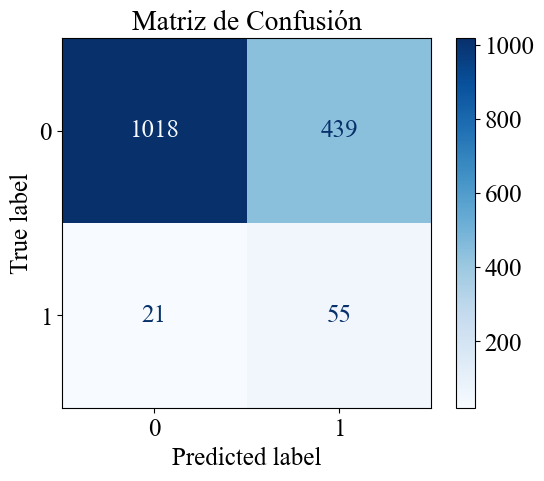

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib as mpl

# Configurar la fuente a Times New Roman y aumentar el tamaño de la fuente
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 18  # Aumentar el tamaño de la fuente a 14 (puedes cambiar este valor)

# Realizar predicciones en el conjunto de prueba
y_pred_op = best_model.predict(X_test)

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred_op)
precision = precision_score(y_test, y_pred_op)
recall = recall_score(y_test, y_pred_op)
f1 = f1_score(y_test, y_pred_op)
f3 = fbeta_score(y_test, y_pred_op, beta=3, zero_division=1)

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("F3 Score:", f3)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_op)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Ajustar título y mostrar la matriz de confusión
plt.title('Matriz de Confusión', fontsize=20)  # Tamaño de fuente específico para el título
plt.show()

# Guardar Modelo

In [14]:
joblib.dump(best_model, "../Modelos/XGBClassifier.joblib")

['../Modelos/XGBClassifier.joblib']